In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [52]:
from fte.simulation.processes import simulate_gaussian_process

In [17]:
TIME_GRID = np.linspace(0, 2)

In [18]:
def propensity_score(*args, **kwargs):
    return 0.5

In [167]:
def conditional_expectation(
    t: np.ndarray,
    d: np.ndarray,
    x: np.ndarray,
    *args,
    **kwargs,
):
    if isinstance(t, np.ndarray) and isinstance(d, np.ndarray):
        t = t.reshape(1, -1)
        d = d.reshape(-1, 1)
    return x.reshape(-1, 1) * np.sin(d * t + (1 - d) * t**2)

In [152]:
def average_treatment_effect(t: np.ndarray, *args, **kwargs):
    return conditional_expectation(t=t, d=1, x=1) - conditional_expectation(
        t=t,
        d=0,
        x=1,
    )

## Plotting

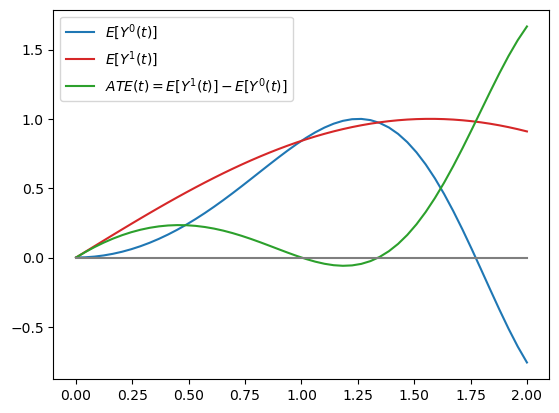

In [154]:
g0 = conditional_expectation(t=TIME_GRID, d=0, x=1)
g1 = conditional_expectation(t=TIME_GRID, d=1, x=1)

fig, ax = plt.subplots(1, 1)
ax.plot(TIME_GRID, g0, color="tab:blue")
ax.plot(TIME_GRID, g1, color="tab:red")
ax.plot(TIME_GRID, g1 - g0, color="tab:green")
ax.plot(TIME_GRID, np.zeros_like(TIME_GRID), color="tab:gray")
ax.legend(
    labels=["$E[Y^{0}(t)]$", "$E[Y^{1}(t)]$", "$ATE(t) = E[Y^{1}(t)] - E[Y^{0}(t)]$"],
)

### Simulate

In [173]:
def simulate(n_samples: int, rng: np.random.Generator):
    treatment_probability = propensity_score()

    d = rng.binomial(1, p=treatment_probability, size=n_samples)
    x = rng.uniform(0.5, 1.5, size=n_samples)

    g = conditional_expectation(t=TIME_GRID, d=d, x=x)

    error = simulate_gaussian_process(
        n_periods=len(TIME_GRID),
        n_samples=n_samples,
        kernel="RBF",
        rng=rng,
        scale=0.02,
    )

    y = g + error.T
    return x, d.astype(bool), y

In [174]:
rng = np.random.default_rng(12345)

x, d, y = simulate(1_000, rng=rng)

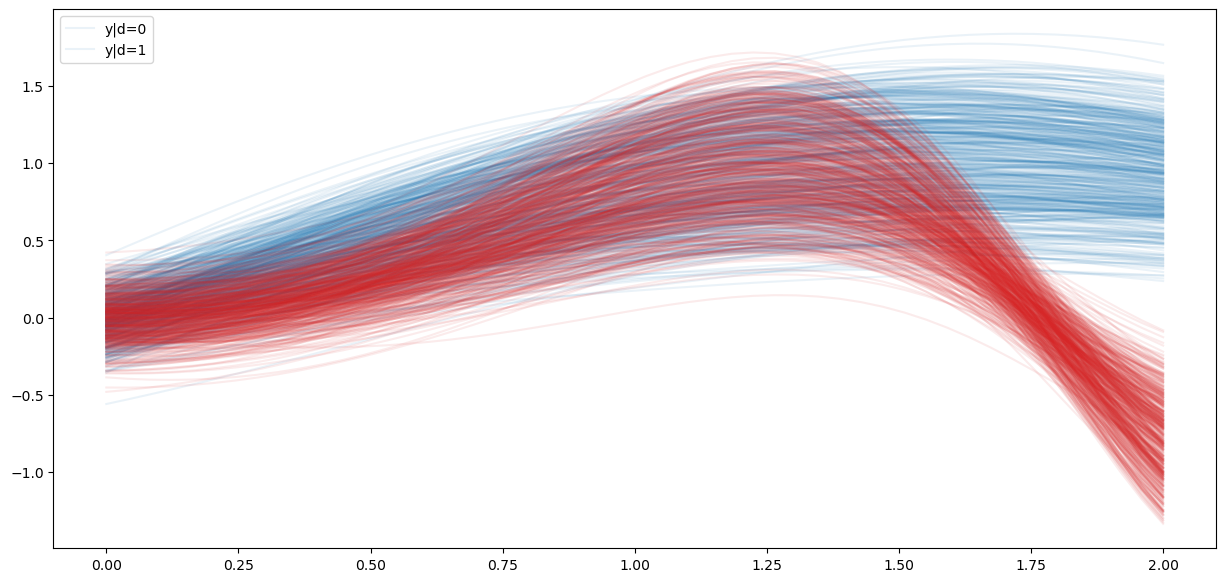

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

_ = ax.plot(TIME_GRID, y[d].T, color="tab:blue", alpha=0.09)
_ = ax.plot(TIME_GRID, y[~d].T, color="tab:red", alpha=0.09)
ax.legend(labels=["y|d=0", "y|d=1"])

### Estimation

In [176]:
def oracle_estimator(t, d, y):
    z = (
        conditional_expectation(t=t, d=1)
        - conditional_expectation(t=t, d=0)
        + d.reshape(-1, 1)
        * (y - conditional_expectation(t=t, d=1))
        / propensity_score()
        - (1 - d.reshape(-1, 1))
        * (y - conditional_expectation(t=t, d=0))
        / (1 - propensity_score())
    )
    estimate = np.mean(z, axis=0)
    variance = np.mean((z - estimate) ** 2, axis=0)
    return {"estimate": estimate, "variance": variance}

In [177]:
def mean_difference(d, y):
    return y[d].mean(axis=0) - y[~d].mean(axis=0)

In [178]:
res = {
    "estimate": oracle_estimator(TIME_GRID, d=d, y=y)["estimate"],
    "ate": average_treatment_effect(TIME_GRID),
    "md": mean_difference(d=d, y=y),
}

TypeError: conditional_expectation() missing 1 required positional argument: 'x'

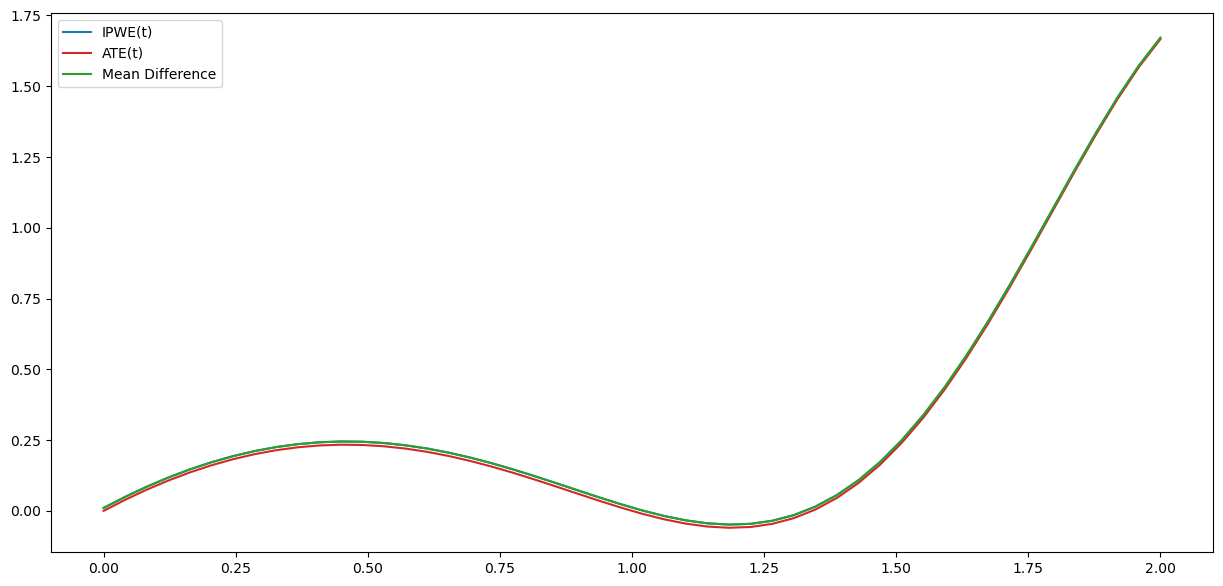

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

_ = ax.plot(TIME_GRID, res["estimate"], color="tab:blue")
_ = ax.plot(TIME_GRID, res["ate"], color="tab:red")
_ = ax.plot(TIME_GRID, res["md"], color="tab:green")
ax.legend(labels=["IPWE(t)", "ATE(t)", "Mean Difference"])